In [1]:
import tensorflow as tf
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 1.12.0


In [7]:
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = tf.keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = tf.keras.layers.Dense(128 * 16 * 16)(generator_input)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = tf.keras.layers.Conv2D(256, 5, padding='same')(x)
x = tf.keras.layers.LeakyReLU()(x)

# Upsample to 32x32
x = tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = tf.keras.layers.LeakyReLU()(x)

# Few more conv layers
x = tf.keras.layers.Conv2D(256, 5, padding='same')(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(256, 5, padding='same')(x)
x = tf.keras.layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = tf.keras.layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = tf.keras.models.Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

In [9]:
discriminator_input = tf.keras.layers.Input(shape=(height, width, channels))
x = tf.keras.layers.Conv2D(128, 3)(discriminator_input)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(128, 4, strides=2)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(128, 4, strides=2)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(128, 4, strides=2)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Flatten()(x)

# One dropout layer - important trick!
x = tf.keras.layers.Dropout(0.4)(x)

# Classification layer
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

discriminator = tf.keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 6, 6, 128)         0         
__________

In [10]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.models.Model(gan_input, gan_output)

gan_optimizer = tf.keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [15]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 2000
batch_size = 20
save_dir = 'C:/gan_images/'

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 10 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generate_frog'+str(step)+'.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

discriminator loss at step 0: 0.57183516
adversarial loss at step 0: 2.8820999
discriminator loss at step 10: 0.37716886
adversarial loss at step 10: 2.8530984
discriminator loss at step 20: 0.54670626
adversarial loss at step 20: 1.408626
discriminator loss at step 30: 0.68696517
adversarial loss at step 30: 0.6255297
discriminator loss at step 40: 0.66109574
adversarial loss at step 40: 0.7060116
discriminator loss at step 50: 0.61513495
adversarial loss at step 50: 0.7746501
discriminator loss at step 60: 0.668649
adversarial loss at step 60: 1.3626076
discriminator loss at step 70: 0.8324156
adversarial loss at step 70: 1.2619544
discriminator loss at step 80: 0.68206394
adversarial loss at step 80: 0.8319505
discriminator loss at step 90: 0.49138823
adversarial loss at step 90: 7.8953896
discriminator loss at step 100: 0.73391825
adversarial loss at step 100: 0.9518771
discriminator loss at step 110: 0.7138305
adversarial loss at step 110: 0.69535404
discriminator loss at step 120

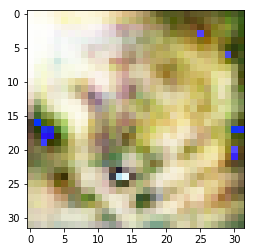

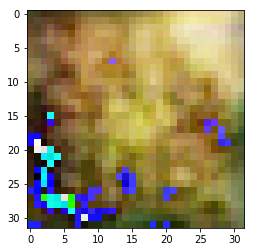

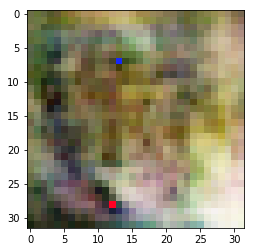

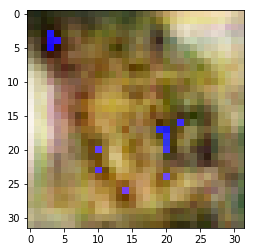

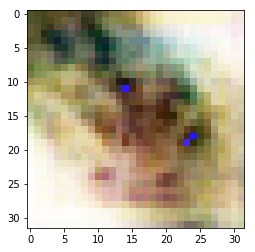

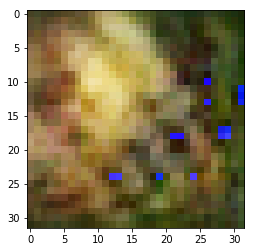

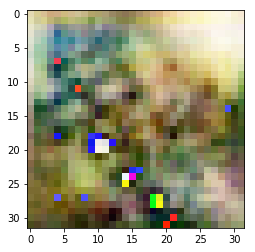

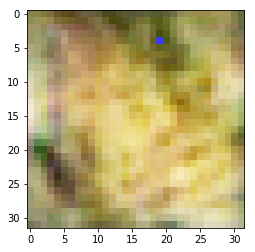

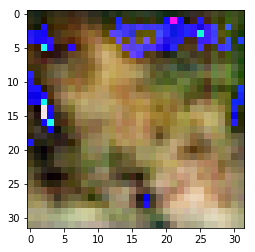

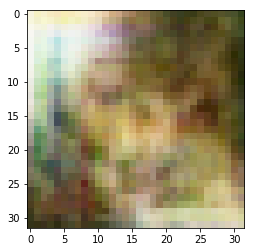

In [16]:
import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()